<a href="https://colab.research.google.com/github/vladislavdarii/Ship-classification-using-Machine-Learning-techniques/blob/main/05_Multi_layer_perceptron.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title 1.0 Imports for Model Training
#Train and test data variables have been saved executing 0.5 to 3.2

import os
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal

#Machine learning
from keras import models
from keras.models import Sequential
from keras.layers import Dense, LeakyReLU
from keras.layers import Dropout
import matplotlib.pyplot as plt
import librosa
#Writing and loading variables
import pickle
from sklearn.metrics import accuracy_score, confusion_matrix
import pandas as pd

#Model visualization
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from tensorflow.keras.layers import BatchNormalization
from keras.callbacks import ReduceLROnPlateau

#Mount drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#@title 1.1 Function: Class Accuracy Plot and Metrics

def plot_class_acc(y_val, y_pred, strr):

  # Initialize the lists for correctly and incorrectly predicted values
  correct_preds = [0, 0, 0, 0]
  incorrect_preds = [0, 0, 0, 0]

  # Loop over the samples in y_test and y_pred
  for i in range(len(y_val)):
      if y_val[i] == y_pred[i]:
          correct_preds[y_val[i]] += 1
      else:
          incorrect_preds[y_val[i]] += 1

  # Set the colors for the bars
  bar_colors = ['#009965', '#a52a2b']

  # Create the bar chart with two parts for each bar
  fig, ax = plt.subplots(figsize=(8, 5))
  ax.bar(range(len(correct_preds)), correct_preds, color=bar_colors[0], label='Correct Predictions')
  ax.bar(range(len(incorrect_preds)), incorrect_preds, bottom=correct_preds, color=bar_colors[1], label='Incorrect Predictions')

  for i, (corr, incorr) in enumerate(zip(correct_preds, incorrect_preds)):
      ax.text(i, corr/2, str(corr), ha='center', va='center', color='white', fontsize=10, fontweight='bold')
      ax.text(i, corr + incorr/2, str(incorr), ha='center', va='center', color='white', fontsize=10, fontweight='bold')

  # Set the x-ticks and labels
  ax.set_xticks(range(len(correct_preds)))
  ax.set_xticklabels(['Class A', 'Class B', 'Class C', 'Class D'])

  # Set the labels and title
  ax.set_xlabel('Boat Type')
  ax.set_ylabel('Count')
  ax.set_title(strr)

  # Add the legend
  ax.legend()

  # Show the plot
  plt.show()

  # #Metric calculation
  # Create confusion matrix
  cm = confusion_matrix(y_val, y_pred)

  # Convert the confusion matrix to a pandas DataFrame
  confusion_matrix_df = pd.DataFrame(cm, columns=['Class A', 'Class B', 'Class C', 'Class D'])

  # Calculate metrics
  metrics_df = calculate_metrics(confusion_matrix_df.values)

  # Print the results
  print("Confusion Matrix:")
  print(confusion_matrix_df)
  print("\nMetrics:")
  print(metrics_df)

  return metrics_df, confusion_matrix_df

def calculate_metrics(confusion_matrix):
    tp = np.diagonal(confusion_matrix)
    fp = confusion_matrix.sum(axis=0) - tp
    fn = confusion_matrix.sum(axis=1) - tp
    tn = confusion_matrix.sum() - (tp + fp + fn)

    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1_score = 2 * (precision * recall) / (precision + recall)
    accuracy = np.trace(confusion_matrix) / confusion_matrix.sum()

    metrics_dict = {
        'Class': ['Class 0', 'Class 1', 'Class 2', 'Class 3'],
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1_score,
        'Accuracy': accuracy
    }
    #Get rid of NaN values
    metrics_dict = pd.DataFrame(metrics_dict)
    metrics_dict.fillna(0, inplace=True)
    return metrics_dict

#@title 5.1 Get final metrics

def metrics_avg_var(metrics):
 row = [0,1,2,3]
 Precision = []
 Recall = []
 F1_Score = []
 Accuracy = []
 Precision_var = []
 Recall_var = []
 F1_Score_var = []
 Accuracy_var = []

 for a in row:
  Precision.append(np.average([df.loc[a, 'Precision'] for df in metrics]))
  Recall.append(np.average([df.loc[a, 'Recall'] for df in metrics]))
  F1_Score.append(np.average([df.loc[a, 'F1 Score'] for df in metrics]))
  Accuracy.append(np.average([df.loc[a, 'Accuracy'] for df in metrics]))
  Precision_var.append(np.std([df.loc[a, 'Precision'] for df in metrics]))
  Recall_var.append(np.std([df.loc[a, 'Recall'] for df in metrics]))
  F1_Score_var.append(np.std([df.loc[a, 'F1 Score'] for df in metrics]))
  Accuracy_var.append(np.std([df.loc[a, 'Accuracy'] for df in metrics]))

 metrics_dict = {
        'Class': ['Class 0', 'Class 1', 'Class 2', 'Class 3'],
        'Precision': Precision,
        'P_std' : Precision_var,
        'Recall': Recall,
        'R_std' : Recall_var,
        'F1 Score': F1_Score,
        'F1_std': F1_Score_var,
        'Accuracy': Accuracy,
        'Acc_std': Accuracy_var
    }


 return pd.DataFrame(metrics_dict)

In [ ]:
#@title 1.2 Model repersentation

def modelrepresent(history):

  plt.figure(figsize=(10, 5))
  plt.grid(True, linestyle='--', alpha=0.6)

  # Plot accuracy and validation accuracy on the left y-axis
  plt.plot(history.history['accuracy'], label='Train Accuracy', color='blue')
  plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='green')
  plt.ylabel('Accuracy', color='blue')
  plt.ylim(0,1)
  plt.xlabel('Epoch')
  plt.twinx()  # Create a second y-axis
  plt.plot(history.history['loss'], label='Train Loss', color='red')
  plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
  plt.ylabel('Loss', color='red')
  plt.title('Accuracy and Loss')
  plt.xlabel('Epoch')
  plt.legend(loc='upper left')
  plt.show()
  return

In [ ]:
#@title 2.1 Data Load

def dataload(datax):
  # Define the directory where the file is saved
  directory = "./drive/MyDrive/TFG/Data/"

  # Load the variables from the file
  with open(os.path.join(directory, datax), "rb") as f:
      X_train, X_test, X_val, y_train, y_test, y_val = pickle.load(f)

  y_train = np.array(y_train)
  y_val = np.array(y_val)
  y_test = np.array(y_test)
  return X_train, X_test, X_val, y_train, y_test, y_val

def save_model(model,modeltype,n):

  model_filename = "MLP_" + str(modeltype) +  "_" + str(n) + ".pkl"

  # Define the directory where you want to save the file
  directory = "./drive/MyDrive/TFG/Models/MLP/"

  # Save the variables to a file
  with open(os.path.join(directory, model_filename), "wb") as f:
      pickle.dump((model), f)
  return

In [ ]:
#@title 3.1 Feature extraction: PSD

def get_psd():

  psd_train = []
  psd_test = []
  psd_val = []

  # Calculate the zero-crossing rate for X_train
  for audio in X_train:
    (f, S)= scipy.signal.welch(audio, 5000, nperseg=2*1024) # best so far 2*1024
    psd_train.append(S/max(S))

  psd_train = np.array(psd_train)

  # Calculate the zero-crossing rate for X_val
  for audio in X_val:
    (f, S)= scipy.signal.welch(audio, 5000, nperseg=2*1024)
    psd_val.append(S/max(S))

  psd_val = np.array(psd_val)

  # Calculate the zero-crossing rate for X_test
  for audio in X_test:
    (f, S)= scipy.signal.welch(audio, 5000, nperseg=2*1024)
    psd_test.append(S/max(S))

  psd_test = np.array(psd_test)
  return psd_train, psd_val, psd_test

In [ ]:
#@title 3.2 Feature extraction: MFCC
def get_mfcc():
# Define the frame length and hop length in samples
  frame_length = 2000
  hop_length =  1000

  # Define the number of MFCCs to extract
  num_mfcc = 15

  # Define the sampling rate of the audio signals
  sr = 52734

  mfcc_train = []
  mfcc_val = []
  mfcc_test = []

  # Extract MFCC features for the training set
  for audio in X_train:
      audio = np.asarray(audio, dtype=float)
      mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=num_mfcc,
                                  n_fft=frame_length, hop_length=hop_length)#, fmin = 25, fmax = 7500)
      mfcc_train.append(mfcc.flatten())

  # Convert the list of MFCCs to a NumPy array and squeeze the dimensions
  mfcc_train = np.array(mfcc_train)


  # Extract MFCC features for the validation set
  for audio in X_val:
      audio = np.asarray(audio, dtype=float)
      mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=num_mfcc,
                                  n_fft=frame_length, hop_length=hop_length)#, fmin = 25, fmax = 7500)
      mfcc_val.append(mfcc.flatten())


  # Convert the list of MFCCs to a NumPy array and squeeze the dimensions
  mfcc_val = np.array(mfcc_val)

  # Extract MFCC features for the test set
  for audio in X_test:
      audio = np.asarray(audio, dtype=float)
      mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=num_mfcc,
                                  n_fft=frame_length, hop_length=hop_length )#,fmin = 25, fmax = 7500)
      mfcc_test.append(mfcc.flatten())

  # Convert the list of MFCCs to a NumPy array and squeeze the dimensions
  mfcc_test = np.array(mfcc_test)
  return  mfcc_train, mfcc_val, mfcc_test

In [ ]:
#@title 4.0 RAW DATA Sequential Model Creation (Failed)


# Create the model
sequential_model = models.Sequential()
sequential_model.add(Dense(256))
sequential_model.add(LeakyReLU(alpha=0.1))
sequential_model.add(Dropout(0.2))
sequential_model.add(Dense(128))
sequential_model.add(LeakyReLU(alpha=0.1))
sequential_model.add(Dropout(0.2))
sequential_model.add(Dense(64))
sequential_model.add(LeakyReLU(alpha=0.1))
sequential_model.add(Dropout(0.2))
sequential_model.add(Dense(16))
sequential_model.add(LeakyReLU(alpha=0.1))
sequential_model.add(Dense(4, activation='softmax'))

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=10, min_lr=0.00005, verbose=1)


# Compile the model
sequential_model.compile(loss='sparse_categorical_crossentropy',
                         optimizer='Adam',
                         metrics=['accuracy'])

sequential_model.summary()

ValueError: ignored

In [ ]:
X_train, X_test, X_val, y_train, y_test, y_val = dataload("data1.pkl")

In [ ]:
#@title 4.1 RAW DATA Sequential Model Training

# Train the model for x epochs
history = sequential_model.fit(X_train, y_train, epochs=15, batch_size = 64, validation_split = 0.2, shuffle=True, callbacks = [reduce_lr])

Epoch 1/15
69/69 [==============================] - 19s 256ms/step - loss: 25721370.0000 - accuracy: 0.2463 - val_loss: 2050538.1250 - val_accuracy: 0.2655 - lr: 0.0010
Epoch 2/15
69/69 [==============================] - 19s 276ms/step - loss: 6830335.5000 - accuracy: 0.2884 - val_loss: 838611.7500 - val_accuracy: 0.3045 - lr: 0.0010
Epoch 3/15
69/69 [==============================] - 18s 258ms/step - loss: 3371700.2500 - accuracy: 0.2743 - val_loss: 622505.5625 - val_accuracy: 0.3264 - lr: 0.0010
Epoch 4/15
11/69 [===>..........................] - ETA: 12s - loss: 2162679.5000 - accuracy: 0.2983

KeyboardInterrupt: ignored

In [ ]:
#@title 5.0 MFCC Sequential Model Creation
def get_MLP_mfcc(n):
  # Create the model
  sequential_model_mfcc = models.Sequential()
  sequential_model_mfcc.add(Dense(256, input_dim=90)) #17
  sequential_model_mfcc.add(BatchNormalization())
  sequential_model_mfcc.add(LeakyReLU(alpha=0.1))
  sequential_model_mfcc.add(Dropout(0.2))

  sequential_model_mfcc.add(Dense(64, input_dim=90)) #17
  sequential_model_mfcc.add(BatchNormalization())
  sequential_model_mfcc.add(Dropout(0.2))
  sequential_model_mfcc.add(LeakyReLU(alpha=0.1))

  sequential_model_mfcc.add(Dense(32, activation = "relu")) #13
  sequential_model_mfcc.add(BatchNormalization())
  sequential_model_mfcc.add(Dropout(0.2))

  sequential_model_mfcc.add(Dense(16, activation = "relu")) #13
  sequential_model_mfcc.add(BatchNormalization())
  sequential_model_mfcc.add(Dropout(0.2))

  sequential_model_mfcc.add(Dense(4, activation='softmax'))


  # Compile the model
  sequential_model_mfcc.compile(loss='sparse_categorical_crossentropy',
                          optimizer='Adam',
                          metrics=['accuracy'])
  reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=10, min_lr=0.00005, verbose=1)
  sequential_model_mfcc.summary()
  history_mfcc = sequential_model_mfcc.fit(mfcc_train, y_train, epochs=150,batch_size = 248, validation_split=0.2, shuffle=True, callbacks = [reduce_lr])
  y_pred = sequential_model_mfcc.predict(mfcc_test)
  y_pred = np.argmax(y_pred, axis=1)  # Convert probabilities to class labels
  metrics, matrix = plot_class_acc(y_test, y_pred, "Test Data")
  save_model(sequential_model_mfcc,"mfcc",n)
  return metrics, matrix

In [ ]:
#@title 5.0 PSD Sequential Model Creation
def get_MLP_psd(n):
  # Create the model
  sequential_model_psd = models.Sequential()
  sequential_model_psd.add(Dense(512, input_dim=1025))
  sequential_model_psd.add(BatchNormalization())
  sequential_model_psd.add(LeakyReLU(alpha=0.1))
  sequential_model_psd.add(Dropout(0.2))

  sequential_model_psd.add(Dense(64, input_dim=90))
  sequential_model_psd.add(BatchNormalization())
  sequential_model_psd.add(Dropout(0.2))
  sequential_model_psd.add(LeakyReLU(alpha=0.1))

  sequential_model_psd.add(Dense(32, activation = "relu"))
  sequential_model_psd.add(BatchNormalization())
  sequential_model_psd.add(Dropout(0.2))

  sequential_model_psd.add(Dense(4, activation='softmax'))


  # Compile the model
  sequential_model_psd.compile(loss='sparse_categorical_crossentropy',
                          optimizer='Adam',
                          metrics=['accuracy'])
  reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=10, min_lr=0.00005, verbose=1)
  sequential_model_psd.summary()

  # Train the model for x epochs
  history_psd = sequential_model_psd.fit(psd_train, y_train, epochs=150,batch_size = 248, validation_split=0.2, shuffle=True, callbacks = [reduce_lr])
  modelrepresent(history_psd)


  # Overfitting test

  y_pred = sequential_model_psd.predict(psd_test)
  y_pred = np.argmax(y_pred, axis=1)  # Convert probabilities to class labels
  metrics, matrix = plot_class_acc(y_test, y_pred, "Test data")
  save_model(sequential_model_psd,"psd",n)
  return metrics, matrix

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_65 (Dense)            (None, 256)               23296     
                                                                 
 batch_normalization_35 (Bat  (None, 256)              1024      
 chNormalization)                                                
                                                                 
 leaky_re_lu_36 (LeakyReLU)  (None, 256)               0         
                                                                 
 dropout_47 (Dropout)        (None, 256)               0         
                                                                 
 dense_66 (Dense)            (None, 64)                16448     
                                                                 
 batch_normalization_36 (Bat  (None, 64)               256       
 chNormalization)                                    

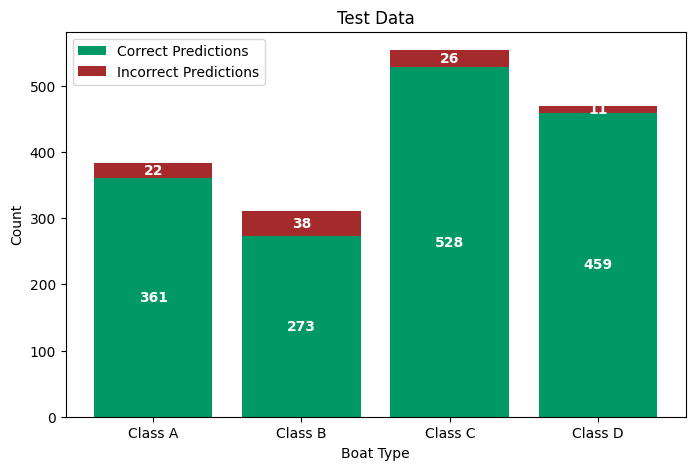

Confusion Matrix:
   Class A  Class B  Class C  Class D
0      361        4       10        8
1        8      273       27        3
2        8       12      528        6
3        6        2        3      459

Metrics:
     Class  Precision  Recall  F1 Score  Accuracy
0  Class 0      0.943   0.943     0.943     0.944
1  Class 1      0.938   0.878     0.907     0.944
2  Class 2      0.930   0.953     0.941     0.944
3  Class 3      0.964   0.977     0.970     0.944
Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_70 (Dense)            (None, 512)               525312    
                                                                 
 batch_normalization_39 (Bat  (None, 512)              2048      
 chNormalization)                                                
                                                                 
 leaky_re_lu_38 (LeakyReLU)  (None, 512)       

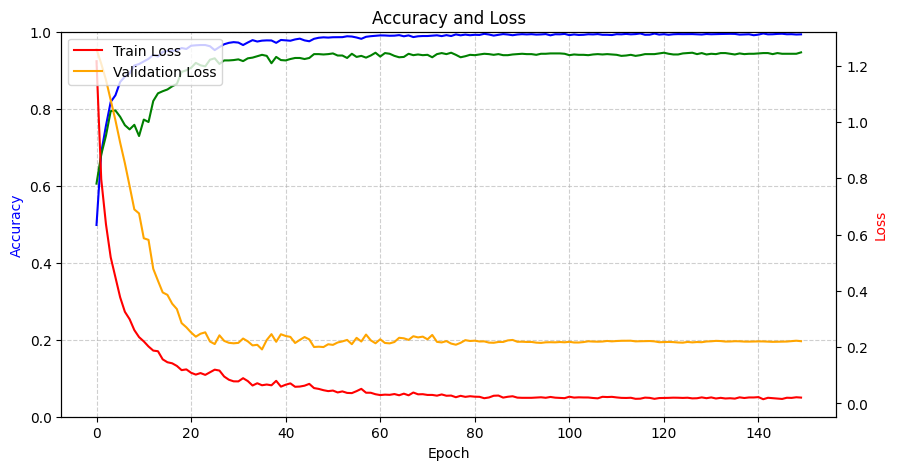

54/54 [==============================] - 0s 2ms/step


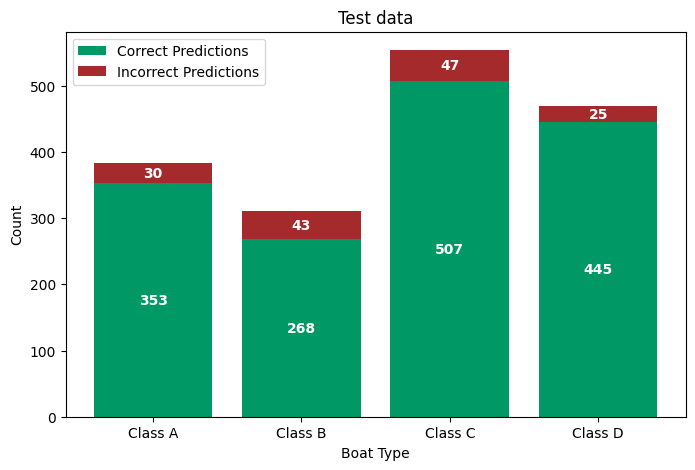

Confusion Matrix:
   Class A  Class B  Class C  Class D
0      353        6       16        8
1        9      268       28        6
2       16       17      507       14
3       10        3       12      445

Metrics:
     Class  Precision  Recall  F1 Score  Accuracy
0  Class 0      0.910   0.922     0.916     0.916
1  Class 1      0.912   0.862     0.886     0.916
2  Class 2      0.901   0.915     0.908     0.916
3  Class 3      0.941   0.947     0.944     0.916
Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_74 (Dense)            (None, 256)               23296     
                                                                 
 batch_normalization_42 (Bat  (None, 256)              1024      
 chNormalization)                                                
                                                                 
 leaky_re_lu_40 (LeakyReLU)  (None, 256)       

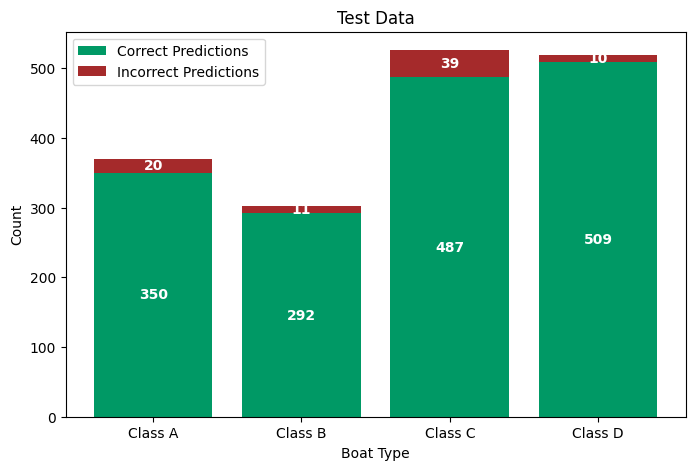

Confusion Matrix:
   Class A  Class B  Class C  Class D
0      350        6        8        6
1        5      292        6        0
2        6       31      487        2
3        4        5        1      509

Metrics:
     Class  Precision  Recall  F1 Score  Accuracy
0  Class 0      0.959   0.946     0.952     0.953
1  Class 1      0.874   0.964     0.917     0.953
2  Class 2      0.970   0.926     0.947     0.953
3  Class 3      0.985   0.981     0.983     0.953
Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_79 (Dense)            (None, 512)               525312    
                                                                 
 batch_normalization_46 (Bat  (None, 512)              2048      
 chNormalization)                                                
                                                                 
 leaky_re_lu_42 (LeakyReLU)  (None, 512)       

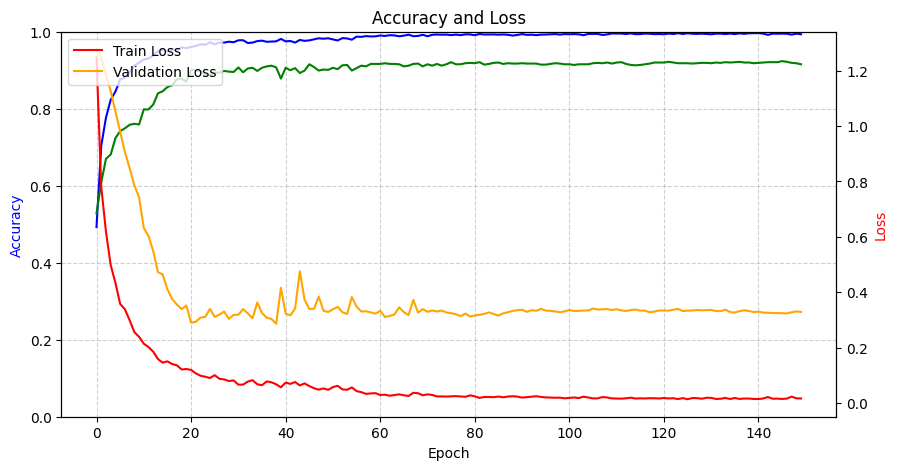

54/54 [==============================] - 0s 3ms/step


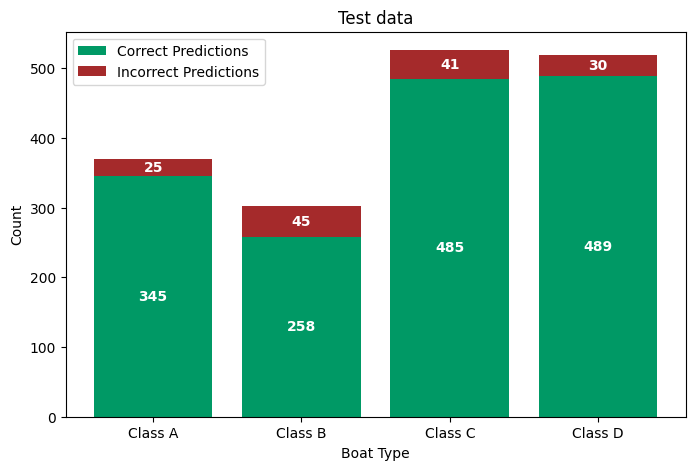

Confusion Matrix:
   Class A  Class B  Class C  Class D
0      345        7        9        9
1       12      258       29        4
2       13       14      485       14
3       12        4       14      489

Metrics:
     Class  Precision  Recall  F1 Score  Accuracy
0  Class 0      0.903   0.932     0.918     0.918
1  Class 1      0.912   0.851     0.881     0.918
2  Class 2      0.903   0.922     0.913     0.918
3  Class 3      0.948   0.942     0.945     0.918
Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_83 (Dense)            (None, 256)               23296     
                                                                 
 batch_normalization_49 (Bat  (None, 256)              1024      
 chNormalization)                                                
                                                                 
 leaky_re_lu_44 (LeakyReLU)  (None, 256)       

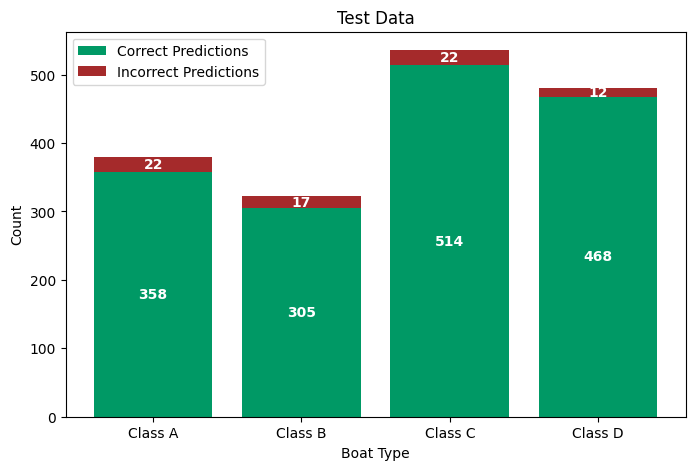

Confusion Matrix:
   Class A  Class B  Class C  Class D
0      358       12        9        1
1        0      305       16        1
2        2       19      514        1
3        2        4        6      468

Metrics:
     Class  Precision  Recall  F1 Score  Accuracy
0  Class 0      0.989   0.942     0.965     0.958
1  Class 1      0.897   0.947     0.921     0.958
2  Class 2      0.943   0.959     0.951     0.958
3  Class 3      0.994   0.975     0.984     0.958
Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_88 (Dense)            (None, 512)               525312    
                                                                 
 batch_normalization_53 (Bat  (None, 512)              2048      
 chNormalization)                                                
                                                                 
 leaky_re_lu_46 (LeakyReLU)  (None, 512)       

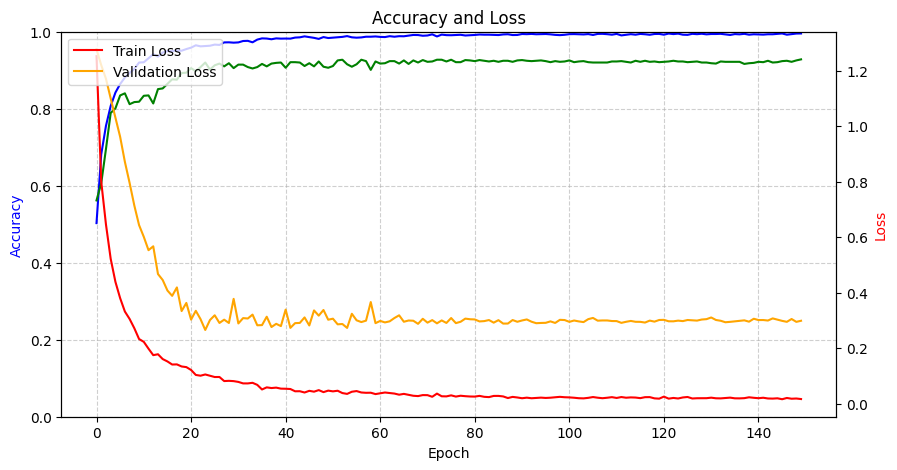

54/54 [==============================] - 0s 3ms/step


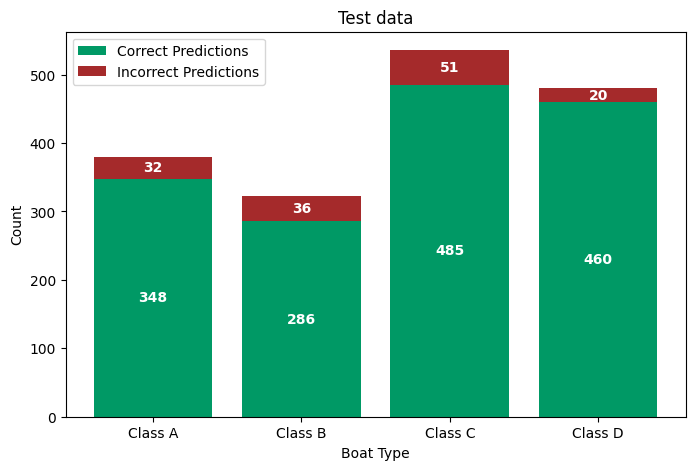

Confusion Matrix:
   Class A  Class B  Class C  Class D
0      348        6       14       12
1        6      286       26        4
2       17       19      485       15
3        9        3        8      460

Metrics:
     Class  Precision  Recall  F1 Score  Accuracy
0  Class 0      0.916   0.916     0.916     0.919
1  Class 1      0.911   0.888     0.899     0.919
2  Class 2      0.910   0.905     0.907     0.919
3  Class 3      0.937   0.958     0.947     0.919
Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_92 (Dense)            (None, 256)               23296     
                                                                 
 batch_normalization_56 (Bat  (None, 256)              1024      
 chNormalization)                                                
                                                                 
 leaky_re_lu_48 (LeakyReLU)  (None, 256)       

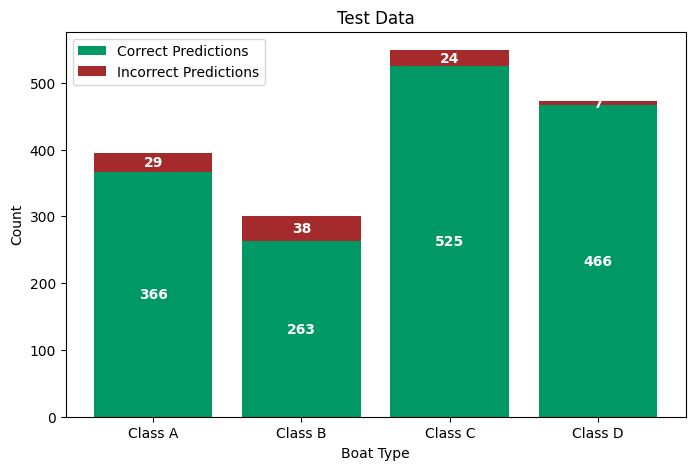

Confusion Matrix:
   Class A  Class B  Class C  Class D
0      366        5        8       16
1        1      263       33        4
2        5       10      525        9
3        2        1        4      466

Metrics:
     Class  Precision  Recall  F1 Score  Accuracy
0  Class 0      0.979   0.927     0.952     0.943
1  Class 1      0.943   0.874     0.907     0.943
2  Class 2      0.921   0.956     0.938     0.943
3  Class 3      0.941   0.985     0.963     0.943
Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_97 (Dense)            (None, 512)               525312    
                                                                 
 batch_normalization_60 (Bat  (None, 512)              2048      
 chNormalization)                                                
                                                                 
 leaky_re_lu_50 (LeakyReLU)  (None, 512)       

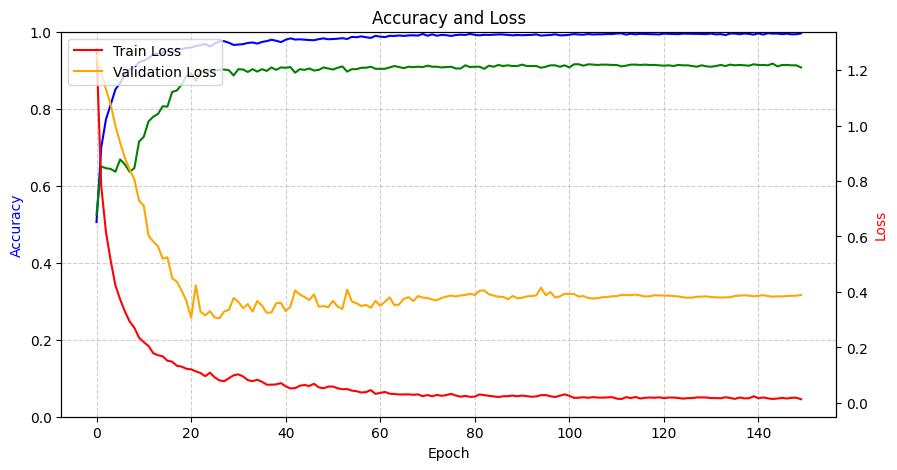

54/54 [==============================] - 0s 2ms/step


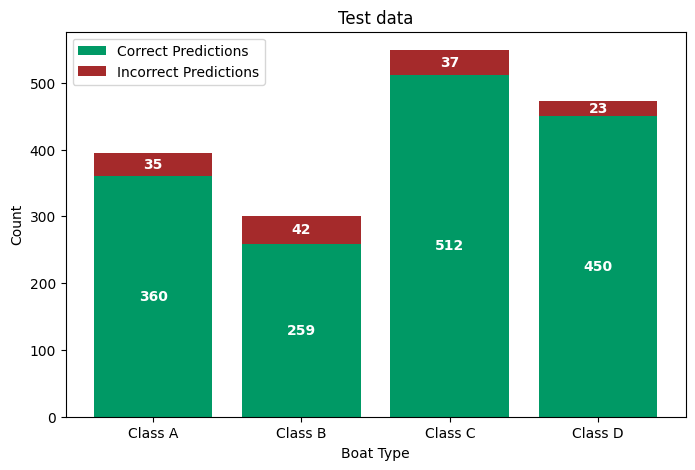

Confusion Matrix:
   Class A  Class B  Class C  Class D
0      360        6       20        9
1        7      259       31        4
2        5       15      512       17
3        6        3       14      450

Metrics:
     Class  Precision  Recall  F1 Score  Accuracy
0  Class 0      0.952   0.911     0.931     0.920
1  Class 1      0.915   0.860     0.887     0.920
2  Class 2      0.887   0.933     0.909     0.920
3  Class 3      0.938   0.951     0.944     0.920
Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_101 (Dense)           (None, 256)               23296     
                                                                 
 batch_normalization_63 (Bat  (None, 256)              1024      
 chNormalization)                                                
                                                                 
 leaky_re_lu_52 (LeakyReLU)  (None, 256)       

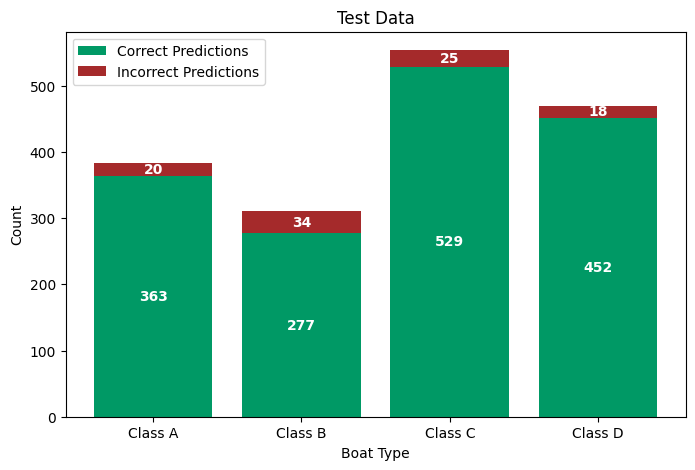

Confusion Matrix:
   Class A  Class B  Class C  Class D
0      363        8        6        6
1        7      277       24        3
2        9       11      529        5
3       10        4        4      452

Metrics:
     Class  Precision  Recall  F1 Score  Accuracy
0  Class 0      0.933   0.948     0.940     0.944
1  Class 1      0.923   0.891     0.907     0.944
2  Class 2      0.940   0.955     0.947     0.944
3  Class 3      0.970   0.962     0.966     0.944
Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_106 (Dense)           (None, 512)               525312    
                                                                 
 batch_normalization_67 (Bat  (None, 512)              2048      
 chNormalization)                                                
                                                                 
 leaky_re_lu_54 (LeakyReLU)  (None, 512)       

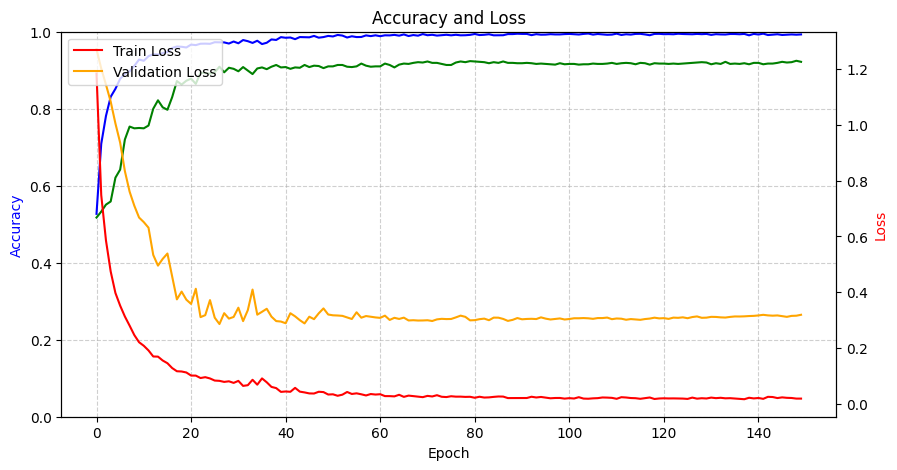

54/54 [==============================] - 0s 2ms/step


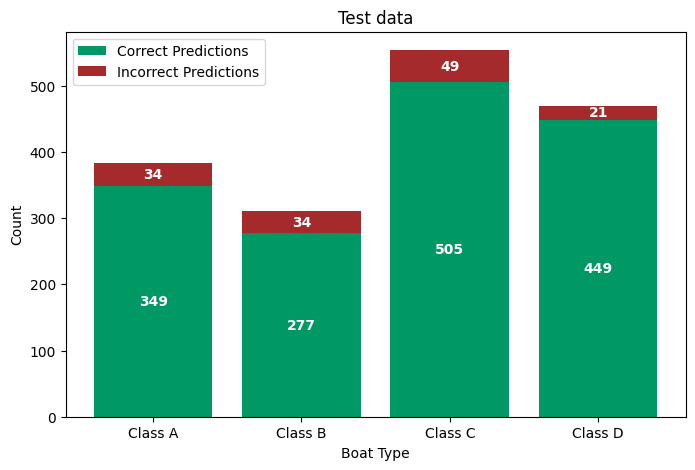

Confusion Matrix:
   Class A  Class B  Class C  Class D
0      349        7       15       12
1        5      277       26        3
2       13       23      505       13
3        7        5        9      449

Metrics:
     Class  Precision  Recall  F1 Score  Accuracy
0  Class 0      0.933   0.911     0.922     0.920
1  Class 1      0.888   0.891     0.889     0.920
2  Class 2      0.910   0.912     0.911     0.920
3  Class 3      0.941   0.955     0.948     0.920


In [ ]:
#@title 5.2 Test results extraction

# Metric activator
raw = 0
mfcc = 1
psd = 1


metrics_raw1 = []
metrics_mfcc1 = []
metrics_psd1 = []
matrix_raw = []
matrix_mfcc = []
matrix_psd = []
val = 1
data = ['data1.pkl','data2.pkl','data3.pkl','data4.pkl','data5.pkl']

for d in data:
  X_train, X_test, X_val, y_train, y_test, y_val = dataload(d)

  if raw == 1:
  # Get raw data
#    metrics, matrix = get_RF_rawdata(val)
    metrics_raw1.append(metrics)
    matrix_raw.append(matrix)
  if mfcc == 1:
  # Get mfcc data
    mfcc_train, mfcc_val, mfcc_test = get_mfcc()
    metrics1, matrix1 = get_MLP_mfcc(val)
    metrics_mfcc1.append(metrics1)
    matrix_mfcc.append(matrix1)
 # Get psd data
  if psd == 1:
    psd_train, psd_val, psd_test = get_psd()
    metrics2, matrix2 = get_MLP_psd(val)
    metrics_psd1.append(metrics2)
    matrix_psd.append(matrix2)
  val = val + 1

pd.options.display.float_format = '{:.3f}'.format

if raw == 1:
  metrics_raw = metrics_avg_var(metrics_raw1)
if mfcc == 1:
  metrics_mfcc = metrics_avg_var(metrics_mfcc1)
if psd == 1:
  metrics_psd = metrics_avg_var(metrics_psd1)


In [ ]:
#@title Print Table

def get_number(row,col, metrics):
 cols = ['Precision','Recall','F1 Score']
 a = metrics.at[row,col]
 highest = 0
 if col in cols:
  for value in metrics[col]:
    if value > a:
      highest = 1
  if highest == 0:
    a = "\highest{" + str(a) + "}"
 return str(a)

def print_table(metrics):

#metrics table formatting


  columns_to_format = ['Precision',
                        'Recall',
                        'F1 Score',
                          'Accuracy']
  metrics[columns_to_format] = metrics[columns_to_format].round(3)
  columns_to_format = ['P_std','R_std','F1_std','Acc_std']
  metrics[columns_to_format] = metrics[columns_to_format].round(3)


  print(
  "Class A                           & " + get_number(0,'Precision',metrics) + "                               & (" + get_number(0,'P_std',metrics) + ")     & " + get_number(0,'Recall',metrics) + "                         & (" + get_number(0,'R_std',metrics) + ")         & " + get_number(0,'F1 Score',metrics) + "                  & (" + get_number(0,'F1_std',metrics) + ")                   \\\\"
  " \\rowcolor[HTML]{EFEFEF} Class B                           & " + get_number(1,'Precision',metrics) + "                               & (" + get_number(1,'P_std',metrics) + ")      & " + get_number(1,'Recall',metrics) + "                         & (" + get_number(1,'R_std',metrics) + ")         & " + get_number(1,'F1 Score',metrics) + "                  & (" + get_number(1,'F1_std',metrics) + ")                  \\\\"
  "Class C                           & " + get_number(2,'Precision',metrics) + "                               & (" + get_number(2,'P_std',metrics) + ")      & " + get_number(2,'Recall',metrics) + "                        & (" + get_number(2,'R_std',metrics) + ")         & " + get_number(2,'F1 Score',metrics) + "                  & (" + get_number(2,'F1_std',metrics) + ")                  \\\\")
  print("\\rowcolor[HTML]{EFEFEF} "
  "Class D                           & " + get_number(3,'Precision',metrics) + "                              & (" + get_number(3,'P_std',metrics) + ")      & " + get_number(3,'Recall',metrics) + "                         & (" + get_number(3,'R_std',metrics) + ")         & " + get_number(3,'F1 Score',metrics) + "                  & (" + get_number(3,'F1_std',metrics) + ")                 \\\\ \midrule"
  "\\multicolumn{1}{c}{\\textbf{Accuracy($\sigma$)}} & \multicolumn{1}{c}{\\textbf{}}       &            & \multicolumn{1}{l}{}          &               & \\textbf{" + get_number(3,'Accuracy',metrics) + "}         & \\textbf{(" + get_number(2,'Acc_std',metrics) + ")}  ")
  return


print_table(metrics_psd)

Class A                           & 0.922                               & (0.014)     & 0.919                         & (0.012)         & 0.921                  & (0.01)                   \\ \rowcolor[HTML]{EFEFEF} Class B                           & 0.9                               & (0.008)      & 0.878                         & (0.018)         & 0.889                  & (0.011)                  \\Class C                           & 0.911                               & (0.011)      & 0.917                        & (0.007)         & 0.914                  & (0.005)                  \\
\rowcolor[HTML]{EFEFEF} Class D                           & \highest{0.94}                              & (0.01)      & \highest{0.95}                         & (0.008)         & \highest{0.945}                  & (0.006)                 \\ \midrule\multicolumn{1}{c}{\textbf{Accuracy($\sigma$)}} & \multicolumn{1}{c}{\textbf{}}       &            & \multicolumn{1}{l}{}          &               & \textbf

In [ ]:
#@title Print Matrix

def get_max_matrix(matrix):
  a = 0
  pos = 5
  tp_max = 0
  for m in matrix:
    tp = sum(np.diagonal(m))
    if tp_max < tp:
      tp_max = tp
      pos = a
    a = a+1
  return pos

def get_matrix(matrix):
  matrix = matrix[get_max_matrix(matrix)]
  col = ['Class A','Class B','Class C','Class D']
  for i in list(range(4)):
    for j in list(range(4)):
      print(j,i,matrix.at[i,col[j]])

print("x y C")
get_matrix(matrix_mfcc)


x y C
0 0 364
1 0 6
2 0 7
3 0 6
0 1 8
1 1 287
2 1 12
3 1 4
0 2 2
1 2 12
2 2 537
3 2 3
0 3 3
1 3 2
2 3 2
3 3 463
